## PLN1 - Procesamiento del Lenguaje Natural I ##

Nombre: José Aviani

Código: a2103

### Desafío 3 ###

---

No vamos a hacer comentarios ni aclaraciones adicionales a todo lo que fue simplememnte tomado de la notebook presentada en la clase (no tiene sentido).

---

### Dataset: ###

#### textos.info ####

##### 'La vuelta al mundo en 80 días' de Julio Verne ####

https://www.textos.info/julio-verne/la-vuelta-al-mundo-en-80-dias/ebook

Utilizamos el mismo dataset que vimos en clase para tener una baseline con el que comparar.

---

Instalamos las librerías necesarias:

In [1]:
%pip install beautifulsoup4 --quiet
%pip install lxml --quiet
%pip install tensorflow --quiet

Hacemos los imports necesarios:

In [2]:
import random
import urllib.request
import bs4 as bs
from tensorflow.keras.utils import pad_sequences
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.layers import Dense, LSTM, Embedding, Dropout, TimeDistributed
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
random.seed(84)

---

Descargamos el dataset:

In [4]:
raw_html = urllib.request.urlopen('https://www.textos.info/julio-verne/la-vuelta-al-mundo-en-80-dias/ebook')
raw_html = raw_html.read()

# Parsear artículo, 'lxml' es el parser a utilizar
article_html = bs.BeautifulSoup(raw_html, 'lxml')

# Encontrar todos los párrafos del HTML (bajo el tag <p>)
# y tenerlos disponible como lista
article_paragraphs = article_html.find_all('p')

article_text = ''

for para in article_paragraphs:
    article_text += para.text + ' '

# pasar todo el texto a minúscula
article_text = article_text.lower()

In [5]:
# en article text se encuentra el texto de todo el libro
article_text[:1000]

' en el año 1872, la casa número 7 de saville-row, burlington gardens \r\n—donde murió sheridan en 1814— estaba habitada por phileas fogg, quien a\r\n pesar de que parecía haber tomado el partido de no hacer nada que \r\npudiese llamar la atención, era uno de los miembros más notables y \r\nsingulares del reformclub de londres. por consiguiente, phileas fogg, personaje enigmático y del cual sólo \r\nse sabía que era un hombre muy galante y de los más cumplidos gentlemen \r\nde la alta sociedad inglesa, sucedía a uno de los más grandes oradores \r\nque honran a inglaterra. decíase que se daba un aire a lo byron —su cabeza, se entiende, \r\nporque, en cuanto a los pies, no tenía defecto alguno—, pero a un byron \r\nde bigote y pastillas, a un byron impasible, que hubiera vivido mil años\r\n sin envejecer. phileas fogg, era inglés de pura cepa; pero quizás no había nacido en\r\n londres. jamás se le había visto en la bolsa ni en el banco, ni en \r\nninguno de los despachos mercantiles de 

---

Realizamos el pre-procesamiento para tokenizar el corpus, estructurar el dataset y separar entre datos de entrenamiento y validación.

Estructuramos el problema de aprendizaje como *many-to-many*:
* Entrada: secuencia de tokens [$x_0$, $x_1$, ..., $x_N$]
* Target: secuencia de tokens [$x_1$, $x_2$, ..., $x_{N+1}$]

In [6]:
# seleccionamos el tamaño de contexto
max_context_size = 100 # TODO:JA

In [7]:
# el vocabulario es el conjunto único de caracteres que existe en todo el texto
chars_vocab = set(article_text)
print(chars_vocab)

# la longitud de vocabulario de caracteres es:
vocab_size = len(chars_vocab)
print(vocab_size)

{'k', 'f', '.', 'r', 'm', '!', '/', 'u', 'é', '1', '4', 'p', 'a', '5', 'i', 'e', 'z', 'h', 'ñ', ',', 't', '-', 'g', 'ó', '(', 'v', 'í', '8', 'á', 'l', ' ', 'x', '"', 'o', '6', '7', 'd', 'j', 'ú', 'c', 'q', ')', '~', '>', '?', 'ü', ':', ';', '3', '<', 'n', 's', 'è', 'w', '\n', '¿', '0', '¡', '»', 'b', '—', 'y', '2', '\t', '\r', '«', '9', "'"}
68


In [8]:
# Construimos los dicionarios que asignan índices a caracteres y viceversa.
# El diccionario `char2idx` servirá como tokenizador.
char2idx = {k: v for v,k in enumerate(chars_vocab)}
idx2char = {v: k for k,v in char2idx.items()}

In [9]:
# tokenizamos el texto completo
tokenized_text = [char2idx[ch] for ch in article_text]

print(tokenized_text[:1000])

[30, 15, 50, 30, 15, 29, 30, 12, 18, 33, 30, 9, 27, 35, 62, 19, 30, 29, 12, 30, 39, 12, 51, 12, 30, 50, 38, 4, 15, 3, 33, 30, 35, 30, 36, 15, 30, 51, 12, 25, 14, 29, 29, 15, 21, 3, 33, 53, 19, 30, 59, 7, 3, 29, 14, 50, 22, 20, 33, 50, 30, 22, 12, 3, 36, 15, 50, 51, 30, 64, 54, 60, 36, 33, 50, 36, 15, 30, 4, 7, 3, 14, 23, 30, 51, 17, 15, 3, 14, 36, 12, 50, 30, 15, 50, 30, 9, 27, 9, 10, 60, 30, 15, 51, 20, 12, 59, 12, 30, 17, 12, 59, 14, 20, 12, 36, 12, 30, 11, 33, 3, 30, 11, 17, 14, 29, 15, 12, 51, 30, 1, 33, 22, 22, 19, 30, 40, 7, 14, 15, 50, 30, 12, 64, 54, 30, 11, 15, 51, 12, 3, 30, 36, 15, 30, 40, 7, 15, 30, 11, 12, 3, 15, 39, 26, 12, 30, 17, 12, 59, 15, 3, 30, 20, 33, 4, 12, 36, 33, 30, 15, 29, 30, 11, 12, 3, 20, 14, 36, 33, 30, 36, 15, 30, 50, 33, 30, 17, 12, 39, 15, 3, 30, 50, 12, 36, 12, 30, 40, 7, 15, 30, 64, 54, 11, 7, 36, 14, 15, 51, 15, 30, 29, 29, 12, 4, 12, 3, 30, 29, 12, 30, 12, 20, 15, 50, 39, 14, 23, 50, 19, 30, 15, 3, 12, 30, 7, 50, 33, 30, 36, 15, 30, 29, 33, 51, 30, 

In [10]:
# separaremos el dataset entre entrenamiento y validación.
# `p_val` será la proporción del corpus que se reservará para validación
# `num_val` es la cantidad de secuencias de tamaño `max_context_size` que se usará en validación
p_val = 0.2
num_val = int(np.ceil(len(tokenized_text)*p_val/max_context_size))

# separamos la porción de texto utilizada en entrenamiento de la de validación.
train_text = tokenized_text[:-num_val*max_context_size]
val_text = tokenized_text[-num_val*max_context_size:]

tokenized_sentences_train = [train_text[init:init+max_context_size] for init in range(len(train_text)-max_context_size+1)]
tokenized_sentences_val = [val_text[i*max_context_size:(i+1)*max_context_size] for i in range(num_val)]

X_train = np.array(tokenized_sentences_train[:-1])
y_train = np.array(tokenized_sentences_train[1:])
X_val = np.array(tokenized_sentences_val[:-1])
y_val = np.array(tokenized_sentences_val[1:])

# --------------------------------------------------
# TODO:JA Parche para entrenar rápido para pruebas
# --------------------------------------------------
# TRAIN_LIMIT = 2000
# VAL_LIMIT   = 200
# X_train = X_train[:TRAIN_LIMIT]
# y_train = y_train[:TRAIN_LIMIT]
# X_val = X_val[:VAL_LIMIT]
# y_val = y_val[:VAL_LIMIT]
# --------------------------------------------------


In [11]:
print(X_train.shape)
print(X_train[0,:10])
print(y_train[0,:10])

(319671, 100)
[30 15 50 30 15 29 30 12 18 33]
[15 50 30 15 29 30 12 18 33 30]


In [12]:
print(X_val.shape)
print(X_val[0,:10])
print(y_val[0,:10])

(799, 100)
[60 36 14 39 14 36 14 36 12  4]
[30 36 15 30 59  7 15 50 30  4]


---

Callback tomado de la notebook presentada en clase:

In [13]:
class PplCallback(keras.callbacks.Callback):

    '''
    Este callback es una solución ad-hoc para calcular al final de cada epoch de
    entrenamiento la métrica de Perplejidad sobre un conjunto de datos de validación.
    La perplejidad es una métrica cuantitativa para evaluar la calidad de la generación de secuencias.
    Además implementa la finalización del entrenamiento (Early Stopping)
    si la perplejidad no mejora después de `patience` epochs.
    '''

    def __init__(self, val_data, history_ppl, model_path, patience=5):
      # El callback lo inicializamos con secuencias de validación sobre las cuales
      # mediremos la perplejidad
      self.val_data = val_data

      self.history_ppl = history_ppl

      self.model_path = model_path

      self.target = []
      self.padded = []

      count = 0
      self.info = []
      self.min_score = np.inf
      self.patience_counter = 0
      self.patience = patience

      # nos movemos en todas las secuencias de los datos de validación
      for seq in self.val_data:

        len_seq = len(seq)
        # armamos todas las subsecuencias
        subseq = [seq[:i] for i in range(1,len_seq)]
        self.target.extend([seq[i] for i in range(1,len_seq)])

        if len(subseq)!=0:

          self.padded.append(pad_sequences(subseq, maxlen=max_context_size, padding='pre'))

          self.info.append((count,count+len_seq))
          count += len_seq

      self.padded = np.vstack(self.padded)


    def on_epoch_end(self, epoch, logs=None):

        # en `scores` iremos guardando la perplejidad de cada secuencia
        scores = []

        predictions = self.model.predict(self.padded,verbose=0)

        # para cada secuencia de validación
        for start,end in self.info:

          # en `probs` iremos guardando las probabilidades de los términos target
          probs = [predictions[idx_seq,-1,idx_vocab] for idx_seq, idx_vocab in zip(range(start,end),self.target[start:end])]

          # calculamos la perplejidad por medio de logaritmos
          scores.append(np.exp(-np.sum(np.log(probs))/(end-start)))

        # promediamos todos los scores e imprimimos el valor promedio
        current_score = np.mean(scores)
        self.history_ppl.append(current_score)
        print(f'\n mean perplexity: {current_score} \n')

        # chequeamos si tenemos que detener el entrenamiento
        if current_score < self.min_score:
          self.min_score = current_score
          self.model.save(self.model_path)
          print("Saved new model!")
          self.patience_counter = 0
        else:
          self.patience_counter += 1
          if self.patience_counter == self.patience:
            print("Stopping training...")
            self.model.stop_training = True


---

In [14]:
models_folder = "models"
Path(models_folder).mkdir(parents=True, exist_ok=True)

Función para graficar un entrenamiento:

In [15]:
def graficar_entrenamiento(hist, history_ppl):
  # Perplejidad de entrenamiento a partir de la loss
  train_ppl = np.exp(hist.history['loss'])

  # Perplejidad de validación calculada por PplCallback
  val_ppl = np.array(history_ppl)

  # Ejes de epochs (1..n)
  epochs = np.arange(1, len(train_ppl) + 1)

  plt.figure(figsize=(8, 5))
  plt.plot(epochs, train_ppl, marker='o', label='Train perplexity')
  plt.plot(epochs, val_ppl, marker='o', label='Validation perplexity')

  plt.xlabel('Epoch')
  plt.ylabel('Perplexity')
  # escalar en log si los valores son muy grandes
  # plt.yscale('log')

  plt.title('Perplejidad por epoch (train vs val)')
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

Funciones auxiliares para preparar contexto y el muestreo:

In [16]:
def prepare_seed(seed_text, char2idx, max_context_size):
    # Convertimos caracteres a índices, ignorando los que no estén en el vocabulario
    seed_idxs = [char2idx[c] for c in seed_text if c in char2idx]

    if len(seed_idxs) == 0:
        # Si la semilla no tiene ningún carácter válido, usamos un índice "neutro"
        seed_idxs = [0]

    # Truncamos si es más largo que max_context_size
    if len(seed_idxs) > max_context_size:
        seed_idxs = seed_idxs[-max_context_size:]

    # Padding por la izquierda si es más corto
    if len(seed_idxs) < max_context_size:
        padding = [0] * (max_context_size - len(seed_idxs))
        seed_idxs = padding + seed_idxs

    return np.array(seed_idxs, dtype=np.int32)


def sample_from_probs(probs, temperature=1.0):
    probs = np.asarray(probs).astype("float64")

    if temperature <= 0:
        temperature = 1e-8  # evitar divisiones por cero / log(0)

    # Ajuste por temperatura
    probs = np.power(probs, 1.0 / temperature)
    probs = probs / np.sum(probs)

    return np.random.choice(len(probs), p=probs)

Generación por Greedy Search:

In [17]:
def generate_text_greedy(model, seed_text, gen_length, char2idx, idx2char, max_context_size):
    context = prepare_seed(seed_text, char2idx, max_context_size)
    generated = list(seed_text)

    for _ in range(gen_length):
        x = context[np.newaxis, :]  # (1, max_context_size)

        # Salida del modelo: (1, seq_len, vocab_size)
        preds = model.predict(x, verbose=0)[0]  # (seq_len, vocab_size)
        probs_next = preds[-1]                  # tomamos la última posición

        # Greedy: índice con mayor probabilidad
        next_idx = np.argmax(probs_next)
        next_char = idx2char[next_idx]
        generated.append(next_char)

        # Actualizamos el contexto (desplazamos e insertamos el nuevo índice)
        context = np.roll(context, -1)
        context[-1] = next_idx

    return "".join(generated)

Generación por Beam Search determinístico:

In [18]:
def generate_text_beam_search(
    model,
    seed_text,
    gen_length,
    char2idx,
    idx2char,
    max_context_size,
    beam_width=3
):
    initial_context = prepare_seed(seed_text, char2idx, max_context_size)

    # Cada elemento del beam es: (lista_de_caracteres, contexto_indices, log_prob_acumulada)
    beam = [
        (list(seed_text), initial_context.copy(), 0.0)
    ]

    for _ in range(gen_length):
        new_beam = []

        for seq_chars, context, log_prob in beam:
            x = context[np.newaxis, :]
            preds = model.predict(x, verbose=0)[0]   # (seq_len, vocab_size)
            probs_next = preds[-1]                   # distribución del último paso

            # Top-k determinístico
            top_indices = np.argsort(probs_next)[::-1][:beam_width]

            for idx in top_indices:
                prob = probs_next[idx]
                if prob <= 0:
                    continue

                new_log_prob = log_prob + np.log(prob)
                next_char = idx2char[idx]
                new_seq_chars = seq_chars + [next_char]

                new_context = np.roll(context.copy(), -1)
                new_context[-1] = idx

                new_beam.append((new_seq_chars, new_context, new_log_prob))

        # Nos quedamos con las beam_width mejores secuencias
        new_beam.sort(key=lambda t: t[2], reverse=True)
        beam = new_beam[:beam_width]

    best_seq_chars, _, _ = beam[0]
    return "".join(best_seq_chars)


Generación por Beam Search estocástico con temperatura:

In [19]:
def generate_text_beam_search_stochastic(
    model,
    seed_text,
    gen_length,
    char2idx,
    idx2char,
    max_context_size,
    beam_width=3,
    temperature=1.0
):
    """
    Beam Search estocástico:
    en lugar de tomar siempre las top-k determinísticas, se muestrean
    beam_width candidatos a partir de la distribución ajustada por temperatura.
    """
    initial_context = prepare_seed(seed_text, char2idx, max_context_size)

    beam = [
        (list(seed_text), initial_context.copy(), 0.0)
    ]

    for _ in range(gen_length):
        new_beam = []

        for seq_chars, context, log_prob in beam:
            x = context[np.newaxis, :]
            preds = model.predict(x, verbose=0)[0]   # (seq_len, vocab_size)
            probs_next = preds[-1].astype("float64")

            # Ajuste por temperatura
            if temperature <= 0:
                temp = 1e-8
            else:
                temp = temperature

            probs_adj = np.power(probs_next, 1.0 / temp)
            probs_adj = probs_adj / np.sum(probs_adj)

            # Muestreamos beam_width índices (con reemplazo)
            sampled_indices = np.random.choice(
                len(probs_adj),
                size=beam_width,
                p=probs_adj
            )

            for idx in sampled_indices:
                prob = probs_adj[idx]
                if prob <= 0:
                    continue

                new_log_prob = log_prob + np.log(prob)
                next_char = idx2char[idx]
                new_seq_chars = seq_chars + [next_char]

                new_context = np.roll(context.copy(), -1)
                new_context[-1] = idx

                new_beam.append((new_seq_chars, new_context, new_log_prob))

        # Nos quedamos con las beam_width mejores según log_prob acumulada
        new_beam.sort(key=lambda t: t[2], reverse=True)
        beam = new_beam[:beam_width]

    best_seq_chars, _, _ = beam[0]
    return "".join(best_seq_chars)


---

Proponemos dos arquitecturas de redes neuronales basadas en unidades recurrentes para implementar un modelo de lenguaje.

---

#### Arquitectura 1 – LSTM profunda con dos capas y regularización ####

Modelo de lenguaje a nivel carácter con una capa de embedding seguida de dos capas LSTM de 256 unidades con dropout y recurrent_dropout, que aprenden patrones de distinta complejidad y ayudan a capturar dependencias de corto y largo alcance. La salida es una capa Dense con activación softmax que modela la distribución de probabilidad del próximo carácter sobre todo el vocabulario.

In [20]:
entrenar_modelo1_flag = True # TODO:JA # Definimos un flag para no reentrenar el modelo si no es necesario para evitar demoras

model1_path = f"{models_folder}/model1.keras"

Definimos el modelo:

In [21]:
# Definimos el modelo para la Arquitectura 1
def obtener_modelo1():
  model = Sequential()
  # Embedding de caracteres
  model.add(
      Embedding(
          input_dim=vocab_size,
          output_dim=128,
          input_length=max_context_size
      )
  )
  # Primera LSTM: devuelve secuencia completa
  model.add(
      LSTM(
          256,
          return_sequences=True,
          dropout=0.2,
          recurrent_dropout=0.2
      )
  )
  # Segunda LSTM: también devuelve secuencia completa
  model.add(
      LSTM(
          256,
          return_sequences=True,
          dropout=0.2,
          recurrent_dropout=0.2
      )
  )
  # Capa de salida aplicada en cada paso temporal
  model.add(
      TimeDistributed(
          Dense(vocab_size, activation='softmax')
      )
  )
  # Compilación
  model.compile(
      loss='sparse_categorical_crossentropy',
      optimizer='rmsprop'
  )
  model.summary()

  return model


model1 = obtener_modelo1()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo:

In [22]:
def entrenar_modelo1(model1, X_train, y_train, X_val, y_val, tokenized_sentences_val, model1_path):
  BATCH_SIZE = 64
  EPOCHS = 5 # Después de ciertas pruebas encontramos que el mejor modelo se alcanza antes de 5 epochs

  history_ppl = []
  hist = model1.fit(
      X_train,
      y_train,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(X_val, y_val),
      callbacks=[PplCallback(tokenized_sentences_val, history_ppl, model1_path)]
  )

  return hist, history_ppl

if entrenar_modelo1_flag:
  modelo1_hist, modelo1_history_ppl = entrenar_modelo1(model1, X_train, y_train, X_val, y_val, tokenized_sentences_val, model1_path)


Epoch 1/5
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - loss: 2.2047
 mean perplexity: 4.60806291282177 

Saved new model!
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 2433s 484ms/step - loss: 2.2047 - val_loss: 6.5136
Epoch 2/5
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - loss: 1.4018
 mean perplexity: 4.320226643681526 

Saved new model!
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 2420s 484ms/step - loss: 1.4018 - val_loss: 7.2614
Epoch 3/5
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - loss: 1.2718
 mean perplexity: 4.400285393595696 

4995/4995 ━━━━━━━━━━━━━━━━━━━━ 2419s 484ms/step - loss: 1.2718 - val_loss: 7.6451
Epoch 4/5
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - loss: 1.1988
 mean perplexity: 4.434425121545791 

4995/4995 ━━━━━━━━━━━━━━━━━━━━ 2427s 486ms/step - loss: 1.1988 - val_loss: 7.9784
Epoch 5/5
4995/4995 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - loss: 1.1486
 mean perplexity: 4.442111493647099 

4995/4995 ━━━━━━━━━━━━━━━━━━━━ 2426s 486ms/step - loss: 1.1486 - val_loss: 8.2001


Graficamos el entrenamiento:

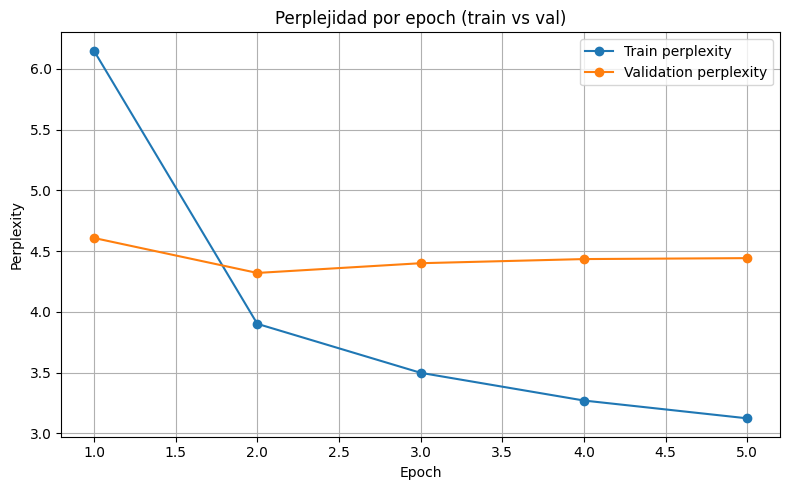

In [23]:
if entrenar_modelo1_flag:
  graficar_entrenamiento(modelo1_hist, modelo1_history_ppl)

Levantamos el mejor modelo entrenado:

In [24]:
model1 = keras.models.load_model(model1_path)

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 128)       │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 100, 68)        │        17,476 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,891,466 (7.22 MB)

 Trainable params: 945,732 (3.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 945,734 (3.61 MB)

Generamos nuevas secuencias a partir de secuencias de contexto.

In [25]:
seed = "Era una noche oscura y "   # ejemplo de contexto inicial
gen_len = 300                      # cantidad de caracteres a generar

Estrategia de greedy search:

In [26]:
def generar_secuencias_modelo1_greedy(seed, gen_len):
  texto_greedy = generate_text_greedy(
      model1,
      seed_text=seed,
      gen_length=gen_len,
      char2idx=char2idx,
      idx2char=idx2char,
      max_context_size=max_context_size
  )
  print("=== Greedy search ===")
  print(texto_greedy)

generar_secuencias_modelo1_greedy(seed, gen_len)

=== Greedy search ===
Era una noche oscura y sus compañeros de la costa de la cabeza, y el pasajero de la costa de la cabeza, y el pasajero de la costa de la cabeza, y el pasajero de la costa de la cabeza, y el pasajero de la costa de la cabeza, y el pasajero de la costa de la cabeza, y el pasajero de la costa de la cabeza, y el pasajero de la


Estrategia de beam search determinístico:

In [27]:
beam_width = 5

In [28]:
def generar_secuencias_modelo1_beam_det(seed, gen_len, beam_width):
  texto_beam = generate_text_beam_search(
      model1,
      seed_text=seed,
      gen_length=gen_len,
      char2idx=char2idx,
      idx2char=idx2char,
      max_context_size=max_context_size,
      beam_width=beam_width
  )
  print(f"\n=== Beam search determinístico (beam_width={beam_width}) ===")
  print(texto_beam)

generar_secuencias_modelo1_beam_det(seed, gen_len, beam_width)


=== Beam search determinístico (beam_width=5) ===
Era una noche oscura y sus compañeros de los pasajeros de los pasajeros de los pasajeros de los pasajeros de los pasajeros de los pasajeros de los pasajeros de los pasajeros de los pasajeros de los pasajeros de los pasajeros de los pasajeros de los pasajeros de los pasajeros de los pasajeros de los pasajeros de los pasaje


Estrategia de beam search estocástico con distintas temperaturas:

In [29]:
def generar_secuencias_modelo1_beam_est(seed, gen_len, beam_width):
  for temp in [0.7, 1.0, 1.3]:
      texto_beam_stoch = generate_text_beam_search_stochastic(
          model1,
          seed_text=seed,
          gen_length=gen_len,
          char2idx=char2idx,
          idx2char=idx2char,
          max_context_size=max_context_size,
          beam_width=beam_width,
          temperature=temp
      )
      print(f"\n=== Beam search estocástico (beam_width={beam_width}, temperature={temp}) ===")
      print(texto_beam_stoch)

generar_secuencias_modelo1_beam_est(seed, gen_len, beam_width)


=== Beam search estocástico (beam_width=5, temperature=0.7) ===
Era una noche oscura y sus compañeros de la costa de la mañana, y el pasajero de la mañana, el pasajero de la mañana, el pasajero de la costa de la mañana, el pasajero de la mañana, el "carnatic" se había contra la condición de la mañana, el pasajero de la mañana, el pasajero de la mañana, y el pasajero de la costa de la 

=== Beam search estocástico (beam_width=5, temperature=1.0) ===
Era una noche oscura y la estación de la costa de la mañana, y el puente de la costa de la cabeza, y el conductor de la mañana, el pasajero de la mañana, y el pasajero de la mañana, el pasajero de la mañana, el tren de la mañana, y el puente de la mañana, y el pasajero de la mañana, y el pasajero de la mañana, el pasajero

=== Beam search estocástico (beam_width=5, temperature=1.3) ===
Era una noche oscura y 
esta religión de la costa de la mañana, el pasajero de la costa de la mañana, el tren se detuvo en el coronel proctor, con la marcha 

TODO:JA
* Dejar ejecutado con 5 epochs.
* Agregar más de un texto de prueba, que sean 3.
* Agregar interpretaciones de los resultados.
* Agregar interpretación de la métrica (perplexity)
* Cuando uso un modelo guardado, lo debo usar con el mismo runetime con que lo generé (estoy usando A100 GPU).


---

TODO:JA Arq 2 Implementar dos arquitecturas más para cubrir las sugerencias SimpleRNN y GRU? (Arq 1 cubre LSTM).

---